In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import SpatialGlue
import skmisc
import numpy as np
import torch_geometric

In [2]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
file_fold = r"D:\SpatialGlue\dataset"

In [4]:
# read data 1
rna_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_RNA.csv")
adt_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_ADT.csv")
meta_df_1 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_100_metadata.csv")

In [5]:
# read data 2
rna_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_RNA.csv")
adt_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_ADT.csv")
meta_df_2 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_1992_nGenes_1000_metadata.csv")

In [6]:
# read data 3
rna_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_RNA.csv")
adt_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_ADT.csv")
meta_df_3 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_100_metadata.csv")

In [7]:
# read data 4
rna_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_RNA.csv")
adt_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_ADT.csv")
meta_df_4 = pd.read_csv(file_fold + r"\Amplify_CBMCs_nCells_5024_nGenes_1000_metadata.csv")

In [8]:
def create_adata(rna_df, adt_df, meta_df):
    adata_rna = sc.AnnData(X = rna_df.values, obs = meta_df, var = pd.DataFrame(index = rna_df.columns), dtype = "float32")
    adata_adt = sc.AnnData(X = adt_df.values, obs = meta_df, var = pd.DataFrame(index = adt_df.columns), dtype = "float32")

    assert (rna_df.index == meta_df.index).all()
    assert (adt_df.index == meta_df.index).all()
    
    adata_rna.var_names_make_unique()
    adata_adt.var_names_make_unique()
    
    adata_rna.obsm['spatial'] = adata_rna.obs[['X','Y']].to_numpy()
    adata_adt.obsm['spatial'] = adata_adt.obs[['X','Y']].to_numpy()

    return adata_rna, adata_adt

In [21]:
adata_rna_1, adata_adt_1 = create_adata(rna_df = rna_df_1, adt_df = adt_df_1, meta_df = meta_df_1)
adata_rna_2, adata_adt_2 = create_adata(rna_df = rna_df_2, adt_df = adt_df_2, meta_df = meta_df_2)
adata_rna_3, adata_adt_3 = create_adata(rna_df = rna_df_3, adt_df = adt_df_3, meta_df = meta_df_3)
adata_rna_4, adata_adt_4 = create_adata(rna_df = rna_df_4, adt_df = adt_df_4, meta_df = meta_df_4)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [38]:
#real data
real_data = sc.read_h5ad(r"D:\SpatialGlue\dataset\adata_all_human_lymph_node_A1.h5ad")

rna_df_real = real_data.obsm['RNA_feat']
adt_df_real = real_data.obsm['Pro_feat']

adata_rna_real = sc.AnnData(X = rna_df_real, obs = real_data.obs)
adata_adt_real = sc.AnnData(X = adt_df_real, obs = real_data.obs)
adata_rna_real.obsm['spatial'] = real_data.obsm['spatial']

In [11]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

def preprocess(adata_rna, adata_adt):
    # RNA
    sc.pp.filter_genes(adata_rna, min_cells=10)
    sc.pp.highly_variable_genes(adata_rna, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata_rna, target_sum=1e4)
    sc.pp.log1p(adata_rna)
    sc.pp.scale(adata_rna)
    
    adata_rna_high =  adata_rna[:, adata_rna.var['highly_variable']]
    adata_rna.obsm['feat'] = pca(adata_rna_high, n_comps=adata_adt.n_vars-1)

    # Protein
    adata_adt = clr_normalize_each_cell(adata_adt)
    sc.pp.scale(adata_adt)
    adata_adt.obsm['feat'] = pca(adata_adt, n_comps=adata_adt.n_vars-1)

    return adata_rna, adata_adt

In [23]:
adata_rna_1, adata_adt_1 = preprocess(adata_rna_1, adata_adt_1)
adata_rna_2, adata_adt_2 = preprocess(adata_rna_2, adata_adt_2)
adata_rna_3, adata_adt_3 = preprocess(adata_rna_3, adata_adt_3)
adata_rna_4, adata_adt_4 = preprocess(adata_rna_4, adata_adt_4)

In [44]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

def preprocess_real(adata_rna, adata_adt):
    # RNA
    adata_rna.obsm['feat'] = pca(adata_rna, n_comps=adata_adt.n_vars-1)

    # Protein
    adata_adt.obsm['feat'] = pca(adata_adt, n_comps=adata_adt.n_vars-1)

    return adata_rna, adata_adt

In [45]:
adata_rna_real, adata_rna_adt = preprocess_real(adata_rna_real, adata_adt_real)

In [28]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data

def buildGraph(adata_rna, adata_adt):
    coords = adata_rna.obsm['spatial'] #Extract spatial coordinate
    features_rna = adata_rna.obsm['feat'] #Extract features of RNA
    features_adt = adata_adt.obsm['feat'] #Extract features of ADT

    #Fit KNN model using spatial coordinates
    #Each points will connect to its 6 nearest neighbors
    knn = NearestNeighbors(n_neighbors = 6).fit(coords)

    #Build spares adjacency matrix
    edge_index_np = knn.kneighbors_graph(coords, mode = 'connectivity').tocoo()

    #Convert to pytorch edge_index and make the graph undirected
    edge_index = torch.tensor(np.vstack((
        np.concatenate([edge_index_np.row, edge_index_np.col]),
        np.concatenate([edge_index_np.col, edge_index_np.row]))),
        dtype = torch.long)
        
    #Convert features to tensor
    X_rna = torch.tensor(features_rna, dtype = torch.float)
    X_adt = torch.tensor(features_adt, dtype = torch.float)

    #Create data object
    data = Data()
    data.num_nodes = X_rna.shape[0]
    data.edge_index = edge_index
    data.x_rna = X_rna   
    data.x_adt = X_adt 

    return data

In [48]:
data_1 = buildGraph(adata_rna_1, adata_adt_1)
data_2 = buildGraph(adata_rna_2, adata_adt_2)
data_3 = buildGraph(adata_rna_3, adata_adt_3)
data_4 = buildGraph(adata_rna_4, adata_adt_4)
data_real = buildGraph(adata_rna_real, adata_adt_real)

In [51]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class Encoder(nn.Module): 
    def __init__(self, in_dim, hidden_dims, dropout): 
        super().__init__() 
        self.gcn_layers = nn.ModuleList()
        last = in_dim
        for h in hidden_dims: 
            self.gcn_layers.append(GCNConv(last, h)) 
            last = h 
        self.dropout = dropout
            
    def forward(self, x, edge_index):
        h = x
        for conv in self.gcn_layers:
            h = conv(h, edge_index)
            h = F.relu(h)
            if self.dropout > 0:
                h = F.dropout(h, p=self.dropout, training=self.training)
        return h

In [101]:
class ModelVGAE(nn.Module):
    def __init__(
        self, dropout,
        in_rna, in_adt,
        branch_dims=(128, 64),
        fusion_dim=128,
        z_dim=32,
        recon_rna_dim=None,
        recon_adt_dim=None,
        recon_spatial_dim=None,   # NEW: optional spatial recon
    ):
        super().__init__()
        # Separate RNA/ADT encoders
        self.rna_branch = Encoder(in_rna, branch_dims, dropout=dropout)
        self.adt_branch = Encoder(in_adt, branch_dims, dropout=dropout)

        # Fusion
        fused_in = branch_dims[-1] * 2
        self.fuse = nn.Sequential(
            nn.Linear(fused_in, fusion_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(fusion_dim, z_dim)
        self.logvar = nn.Linear(fusion_dim, z_dim)

        # Optional reconstruction heads (feature decoders)
        self.recon_rna = None
        self.recon_adt = None
        self.recon_spatial = None

        if recon_rna_dim is not None:
            self.recon_rna = nn.Sequential(
                nn.Linear(z_dim, fusion_dim),
                nn.ReLU(),
                nn.Linear(fusion_dim, recon_rna_dim),
            )
        if recon_adt_dim is not None:
            self.recon_adt = nn.Sequential(
                nn.Linear(z_dim, fusion_dim),
                nn.ReLU(),
                nn.Linear(fusion_dim, recon_adt_dim),
            )
        if recon_spatial_dim is not None:
            self.recon_spatial = nn.Sequential(
                nn.Linear(z_dim, fusion_dim),
                nn.ReLU(),
                nn.Linear(fusion_dim, recon_spatial_dim),
            )

    def encode(self, x_rna, x_adt, edge_index):
        h_rna = self.rna_branch(x_rna, edge_index)
        h_adt = self.adt_branch(x_adt, edge_index)
        h = torch.cat([h_rna, h_adt], dim=-1)
        h = self.fuse(h)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_graph(self, z, edge_index):
        # Inner-product VGAE decoder
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1))

    def forward(self, x_rna, x_adt, edge_index):
        mu, logvar = self.encode(x_rna, x_adt, edge_index)
        z = self.reparam(mu, logvar)

        # feature reconstructions
        xhat_rna = self.recon_rna(z) if self.recon_rna else None
        xhat_adt = self.recon_adt(z) if self.recon_adt else None
        xhat_spatial = self.recon_spatial(z) if self.recon_spatial else None

        # graph reconstruction (edge probabilities)
        adj_pred = self.decode_graph(z, edge_index)

        return z, mu, logvar, xhat_rna, xhat_adt, xhat_spatial, adj_pred

In [132]:
#LOSS
from torch_geometric.utils import negative_sampling, to_undirected

def edge_recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_edge_index = edge_index
    num_pos = pos_edge_index.size(1)
    num_neg = int(neg_ratio * num_pos)

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_neg,
        method="sparse"
    )

    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=-1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))
    return pos_loss + neg_loss

def kl_loss(mu, logvar, eps=1e-9):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp() + eps)

In [139]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

def train_vgae(model, data, epochs, device,
               lr=1e-3, weight_decay=1e-5, dropout=0.2,
               lambda_rna=1.0, lambda_adt=1.0):


    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    edge_index = data.edge_index.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        z, mu, logvar, xhat_rna, xhat_adt, _, adj_pred = model(
            data.x_rna.to(device),
            data.x_adt.to(device),
            edge_index
        )

        # ===== Graph reconstruction loss (pos + neg edges) =====
        pos_pred = model.decode_graph(z, edge_index)
        pos_label = torch.ones_like(pos_pred)

        # sample negative edges
        neg_edge_index = negative_sampling(
            edge_index, num_nodes=z.size(0), num_neg_samples=edge_index.size(1)
        )
        neg_pred = model.decode_graph(z, neg_edge_index)
        neg_label = torch.zeros_like(neg_pred)

        # combine pos & neg
        preds = torch.cat([pos_pred, neg_pred])
        labels = torch.cat([pos_label, neg_label])
        loss_edges = F.binary_cross_entropy(preds, labels)

        # ===== KL loss =====
        loss_kld = kl_loss(mu, logvar)

        # ===== Feature reconstruction losses =====
        loss_rna = F.mse_loss(xhat_rna, data.x_rna.to(device)) if xhat_rna is not None else 0
        loss_adt = F.mse_loss(xhat_adt, data.x_adt.to(device)) if xhat_adt is not None else 0

        # ===== Total loss =====
        loss = loss_edges + loss_kld + lambda_rna * loss_rna + lambda_adt * loss_adt

        # Backprop
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1:03d} | "
              f"Total: {loss.item():.4f} | "
              f"Graph: {loss_edges.item():.4f} | "
              f"KLD: {loss_kld.item():.4f} | "
              f"RNA: {float(loss_rna):.4f} | "
              f"ADT: {float(loss_adt):.4f}")

    # Final embeddings
    model.eval()
    with torch.no_grad():
        z, _, _, _, _, _, _ = model(
            data.x_rna.to(device),
            data.x_adt.to(device),
            edge_index
        )

    return z

In [86]:
from scipy.spatial import cKDTree
from scipy.stats import mode
from collections import Counter

def cKD_refine_label(coords, labels, k):
    # Step 1: Build KD-Tree
    tree = cKDTree(coords.copy())
    # Step 2: Find k-nearest neighbors for each spot
    # k+1 because the closest point is itself
    distances, neighbors = tree.query(coords, k=k+1)
    # Exclude self-neighbor (first column)
    neighbors = neighbors[:, 1:]
    # Step 3: Reassign labels
    new_labels = labels.copy()
    for i, nbrs in enumerate(neighbors):
        # Get the labels of neighboring spots
        neighbor_labels = labels[nbrs]
        # Find the most common label among neighbors
        # most_common_label = mode(neighbor_labels).mode[0]
        most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
        # Reassign the label
        new_labels[i] = most_common_label
    return (new_labels)

### Data 1: Amplify_CBMCs_nCells_1992_nGenes_100

In [140]:
epochs = 500

model_1 = ModelVGAE(
    dropout = 0.2,
    in_rna = data_1.x_rna.shape[1],
    in_adt = data_1.x_adt.shape[1],
    recon_rna_dim = data_1.x_rna.shape[1],
    recon_adt_dim = data_1.x_adt.shape[1],
    recon_spatial_dim = data_1.edge_index.shape[1]
    ).to(device)
z = train_vgae(model_1, data = data_1, epochs = epochs, device = device)

Epoch 001 | Total: 13.8333 | Graph: 2.3123 | KLD: 0.0076 | RNA: 10.2896 | ADT: 1.2238
Epoch 002 | Total: 13.7198 | Graph: 2.2423 | KLD: 0.0069 | RNA: 10.2556 | ADT: 1.2150
Epoch 003 | Total: 13.6324 | Graph: 2.1844 | KLD: 0.0070 | RNA: 10.2313 | ADT: 1.2097
Epoch 004 | Total: 13.5179 | Graph: 2.1065 | KLD: 0.0079 | RNA: 10.2030 | ADT: 1.2005
Epoch 005 | Total: 13.4409 | Graph: 2.0371 | KLD: 0.0097 | RNA: 10.2004 | ADT: 1.1937
Epoch 006 | Total: 13.3838 | Graph: 2.0168 | KLD: 0.0120 | RNA: 10.1716 | ADT: 1.1834
Epoch 007 | Total: 13.2951 | Graph: 1.9566 | KLD: 0.0154 | RNA: 10.1392 | ADT: 1.1838
Epoch 008 | Total: 13.1766 | Graph: 1.8852 | KLD: 0.0210 | RNA: 10.0897 | ADT: 1.1807
Epoch 009 | Total: 13.0519 | Graph: 1.8275 | KLD: 0.0279 | RNA: 10.0213 | ADT: 1.1752
Epoch 010 | Total: 12.9432 | Graph: 1.7454 | KLD: 0.0365 | RNA: 9.9854 | ADT: 1.1759
Epoch 011 | Total: 12.8510 | Graph: 1.7213 | KLD: 0.0492 | RNA: 9.9117 | ADT: 1.1688
Epoch 012 | Total: 12.6661 | Graph: 1.6119 | KLD: 0.0622

In [141]:
import pandas as pd

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

In [142]:
from sklearn.mixture import BayesianGaussianMixture

adata = adata_rna_1.copy()
num_cluster_1 = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster_1,
                                #covariance_type = covariance_type, 
                                random_state = 42,
                                #init_params = '', 
                                #n_init = 1, 
                                #max_iter = 1000
                               )
bayes.fit(df_z)

BayesianGaussianMixture(n_components=15, random_state=42)

In [143]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 50)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


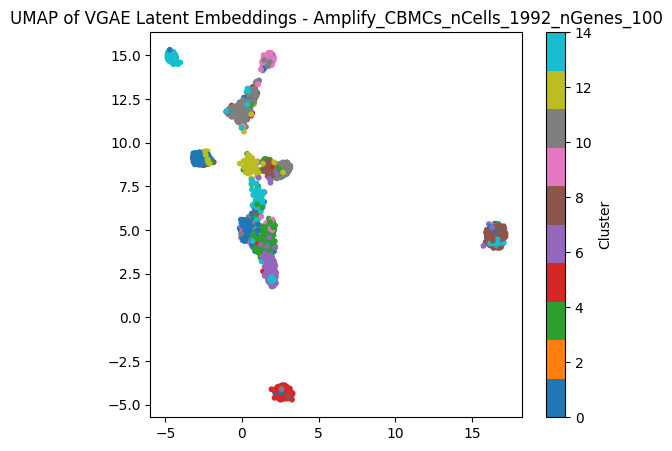

In [144]:
import umap
import matplotlib.pyplot as plt

dataset = "Amplify_CBMCs_nCells_1992_nGenes_100"

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset}")
plt.show()

In [145]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = pred 

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.4081
NMI: 0.6440
HOM: 0.6337


In [146]:
torch.save(model_1, "model_1.pth")

### Data 2: Amplify_CBMCs_nCells_1992_nGenes_1000

In [147]:
dataset = "Amplify_CBMCs_nCells_1992_nGenes_1000"

In [148]:
epochs = 500

model_2 = ModelVGAE(
    dropout = 0.2,
    in_rna = data_2.x_rna.shape[1],
    in_adt = data_2.x_adt.shape[1],
    recon_rna_dim = data_2.x_rna.shape[1],
    recon_adt_dim = data_2.x_adt.shape[1],
    recon_spatial_dim = data_2.edge_index.shape[1]
    ).to(device)
z = train_vgae(model_2, data = data_2, epochs = epochs, device = device)

Epoch 001 | Total: 94.7678 | Graph: 2.5597 | KLD: 0.0478 | RNA: 90.9168 | ADT: 1.2434
Epoch 002 | Total: 94.1913 | Graph: 2.3139 | KLD: 0.0409 | RNA: 90.6144 | ADT: 1.2221
Epoch 003 | Total: 93.7084 | Graph: 2.1744 | KLD: 0.0429 | RNA: 90.2760 | ADT: 1.2151
Epoch 004 | Total: 93.3102 | Graph: 2.0952 | KLD: 0.0474 | RNA: 89.9686 | ADT: 1.1990
Epoch 005 | Total: 92.9028 | Graph: 2.1109 | KLD: 0.0586 | RNA: 89.5452 | ADT: 1.1881
Epoch 006 | Total: 92.4866 | Graph: 2.1237 | KLD: 0.0732 | RNA: 89.1153 | ADT: 1.1743
Epoch 007 | Total: 91.9578 | Graph: 2.3566 | KLD: 0.0983 | RNA: 88.3363 | ADT: 1.1665
Epoch 008 | Total: 91.5663 | Graph: 2.6404 | KLD: 0.1284 | RNA: 87.6466 | ADT: 1.1510
Epoch 009 | Total: 90.8246 | Graph: 2.8006 | KLD: 0.1728 | RNA: 86.7087 | ADT: 1.1426
Epoch 010 | Total: 90.2548 | Graph: 3.2213 | KLD: 0.2280 | RNA: 85.6696 | ADT: 1.1358
Epoch 011 | Total: 89.0786 | Graph: 3.6307 | KLD: 0.3132 | RNA: 84.0155 | ADT: 1.1191
Epoch 012 | Total: 88.0213 | Graph: 4.1889 | KLD: 0.41

In [149]:
import pandas as pd

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

In [150]:
from sklearn.mixture import BayesianGaussianMixture

adata = adata_rna_2.copy()
num_cluster = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster,
                                random_state = 42)
bayes.fit(df_z)

BayesianGaussianMixture(n_components=15, random_state=42)

In [ ]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 50)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


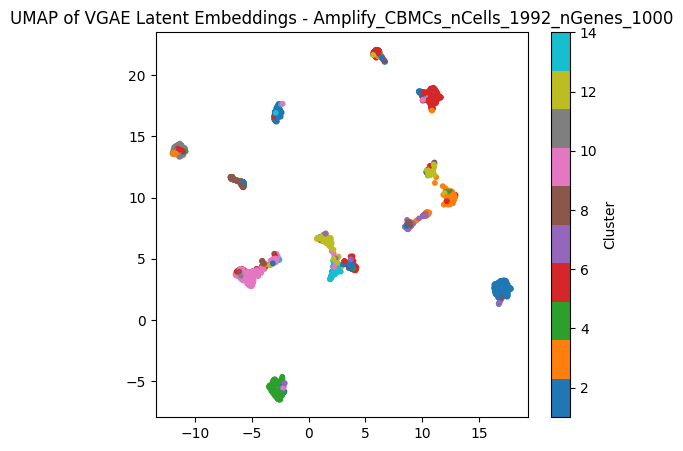

In [152]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset}")
plt.show()

In [153]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = pred 

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3563
NMI: 0.6029
HOM: 0.5817


In [154]:
torch.save(model_2, "model_2.pth")

### Data 3: Amplify_CBMCs_nCells_5024_nGenes_100

In [155]:
dataset = "Amplify_CBMCs_nCells_5024_nGenes_100"

In [156]:
epochs = 500

model_3 = ModelVGAE(
    dropout = 0.2,
    in_rna = data_3.x_rna.shape[1],
    in_adt = data_3.x_adt.shape[1],
    recon_rna_dim = data_3.x_rna.shape[1],
    recon_adt_dim = data_3.x_adt.shape[1],
    recon_spatial_dim = data_3.edge_index.shape[1]
    ).to(device)
z = train_vgae(model_3, data = data_3, epochs = epochs, device = device)

Epoch 001 | Total: 13.8424 | Graph: 2.2783 | KLD: 0.0117 | RNA: 10.3436 | ADT: 1.2088
Epoch 002 | Total: 13.7370 | Graph: 2.2096 | KLD: 0.0103 | RNA: 10.3132 | ADT: 1.2039
Epoch 003 | Total: 13.5853 | Graph: 2.1175 | KLD: 0.0101 | RNA: 10.2680 | ADT: 1.1898
Epoch 004 | Total: 13.4450 | Graph: 2.0323 | KLD: 0.0110 | RNA: 10.2149 | ADT: 1.1867
Epoch 005 | Total: 13.3618 | Graph: 1.9577 | KLD: 0.0133 | RNA: 10.2034 | ADT: 1.1874
Epoch 006 | Total: 13.2222 | Graph: 1.8888 | KLD: 0.0173 | RNA: 10.1362 | ADT: 1.1799
Epoch 007 | Total: 13.0855 | Graph: 1.8092 | KLD: 0.0225 | RNA: 10.0773 | ADT: 1.1765
Epoch 008 | Total: 12.9263 | Graph: 1.7300 | KLD: 0.0303 | RNA: 10.0004 | ADT: 1.1657
Epoch 009 | Total: 12.7596 | Graph: 1.6488 | KLD: 0.0409 | RNA: 9.9075 | ADT: 1.1624
Epoch 010 | Total: 12.6391 | Graph: 1.6030 | KLD: 0.0545 | RNA: 9.8263 | ADT: 1.1553
Epoch 011 | Total: 12.4451 | Graph: 1.5379 | KLD: 0.0725 | RNA: 9.6862 | ADT: 1.1485
Epoch 012 | Total: 12.3122 | Graph: 1.5204 | KLD: 0.0952 

In [157]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

adata = adata_rna_3.copy()
num_cluster = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster,
                                random_state = 42)
bayes.fit(df_z)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=15, random_state=42)

In [158]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 50)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


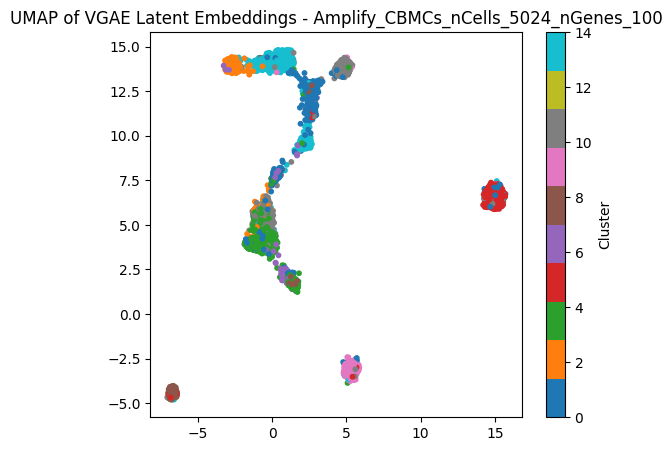

In [159]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset}")
plt.show()

In [160]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = pred 

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.3858
NMI: 0.6386
HOM: 0.6171


In [161]:
torch.save(model_3, "model_3.pth")

In [162]:
df_z.to_csv("z3.csv")

### Data 4: Amplify_CBMCs_nCells_5024_nGenes_1000

In [163]:
dataset = "Amplify_CBMCs_nCells_5024_nGenes_1000"

In [164]:
epochs = 500

model_4 = ModelVGAE(
    dropout = 0.2,
    in_rna = data_4.x_rna.shape[1],
    in_adt = data_4.x_adt.shape[1],
    recon_rna_dim = data_4.x_rna.shape[1],
    recon_adt_dim = data_4.x_adt.shape[1],
    recon_spatial_dim = data_4.edge_index.shape[1]
    ).to(device)
z = train_vgae(model_4, data = data_4, epochs = epochs, device = device)

Epoch 001 | Total: 95.0393 | Graph: 2.7480 | KLD: 0.0408 | RNA: 91.0155 | ADT: 1.2349
Epoch 002 | Total: 94.4617 | Graph: 2.5275 | KLD: 0.0304 | RNA: 90.6828 | ADT: 1.2209
Epoch 003 | Total: 93.9771 | Graph: 2.3571 | KLD: 0.0280 | RNA: 90.3855 | ADT: 1.2064
Epoch 004 | Total: 93.5459 | Graph: 2.2255 | KLD: 0.0301 | RNA: 90.0896 | ADT: 1.2008
Epoch 005 | Total: 92.9524 | Graph: 2.0944 | KLD: 0.0368 | RNA: 89.6188 | ADT: 1.2025
Epoch 006 | Total: 92.4932 | Graph: 2.0609 | KLD: 0.0472 | RNA: 89.1980 | ADT: 1.1872
Epoch 007 | Total: 91.9963 | Graph: 2.1058 | KLD: 0.0633 | RNA: 88.6453 | ADT: 1.1820
Epoch 008 | Total: 91.3955 | Graph: 2.2841 | KLD: 0.0874 | RNA: 87.8454 | ADT: 1.1787
Epoch 009 | Total: 90.6920 | Graph: 2.4508 | KLD: 0.1194 | RNA: 86.9542 | ADT: 1.1676
Epoch 010 | Total: 89.8509 | Graph: 2.7484 | KLD: 0.1623 | RNA: 85.7886 | ADT: 1.1516
Epoch 011 | Total: 88.9812 | Graph: 3.1896 | KLD: 0.2184 | RNA: 84.4366 | ADT: 1.1366
Epoch 012 | Total: 88.2048 | Graph: 4.0916 | KLD: 0.29

In [165]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

adata = adata_rna_4.copy()
num_cluster = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster,
                                random_state = 42)
bayes.fit(df_z)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=15, random_state=42)

In [166]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 50)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


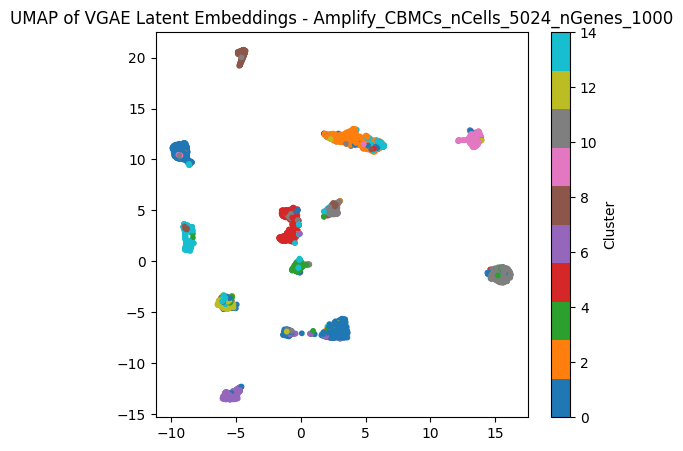

In [167]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset}")
plt.show()

In [168]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = pred 

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.4017
NMI: 0.6384
HOM: 0.6160


In [169]:
torch.save(model_4, "model_4.pth")
df_z.to_csv("z4.csv")

### Data 5: Real data

In [170]:
dataset = "Real Data"

In [172]:
epochs = 500

model_5 = ModelVGAE(
    dropout = 0.2,
    in_rna = data_real.x_rna.shape[1],
    in_adt = data_real.x_adt.shape[1],
    recon_rna_dim = data_real.x_rna.shape[1],
    recon_adt_dim = data_real.x_adt.shape[1],
    recon_spatial_dim = data_real.edge_index.shape[1]
    ).to(device)
z = train_vgae(model_5, data = data_real, epochs = epochs, device = device)

Epoch 001 | Total: 10.5880 | Graph: 2.3710 | KLD: 0.0138 | RNA: 7.0847 | ADT: 1.1186
Epoch 002 | Total: 10.3939 | Graph: 2.1980 | KLD: 0.0109 | RNA: 7.0758 | ADT: 1.1091
Epoch 003 | Total: 10.2886 | Graph: 2.1139 | KLD: 0.0099 | RNA: 7.0629 | ADT: 1.1020
Epoch 004 | Total: 10.2205 | Graph: 2.0628 | KLD: 0.0108 | RNA: 7.0513 | ADT: 1.0957
Epoch 005 | Total: 10.1374 | Graph: 1.9866 | KLD: 0.0132 | RNA: 7.0476 | ADT: 1.0900
Epoch 006 | Total: 10.0478 | Graph: 1.9148 | KLD: 0.0168 | RNA: 7.0317 | ADT: 1.0845
Epoch 007 | Total: 9.9310 | Graph: 1.7979 | KLD: 0.0222 | RNA: 7.0303 | ADT: 1.0805
Epoch 008 | Total: 9.8870 | Graph: 1.7563 | KLD: 0.0303 | RNA: 7.0228 | ADT: 1.0776
Epoch 009 | Total: 9.7685 | Graph: 1.6413 | KLD: 0.0411 | RNA: 7.0120 | ADT: 1.0742
Epoch 010 | Total: 9.6958 | Graph: 1.5709 | KLD: 0.0561 | RNA: 6.9974 | ADT: 1.0714
Epoch 011 | Total: 9.6133 | Graph: 1.4824 | KLD: 0.0746 | RNA: 6.9879 | ADT: 1.0684
Epoch 012 | Total: 9.5079 | Graph: 1.3750 | KLD: 0.0978 | RNA: 6.9714 

In [178]:
adata_rna_real.obs['true_label_level_0'].unique()

['medulla sinuses', 'medulla cords', 'cortex', 'pericapsular adipose tissue', 'follicle', 'capsule', 'hilum', 'medulla vessels', 'subcapsular sinus', 'trabeculae']
Categories (10, object): ['capsule', 'cortex', 'follicle', 'hilum', ..., 'medulla vessels', 'pericapsular adipose tissue', 'subcapsular sinus', 'trabeculae']

In [179]:
adata_rna_real.obs['true_label_level_1'].unique()

['medulla', 'cortex', 'pericapsular adipose tissue', 'follicle', 'capsule', 'hilum', 'subcapsular sinus', 'trabeculae']
Categories (8, object): ['capsule', 'cortex', 'follicle', 'hilum', 'medulla', 'pericapsular adipose tissue', 'subcapsular sinus', 'trabeculae']

In [232]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

# Cluster for true label level 0
adata = adata_rna_real.copy()
adata.obs['label'] = adata.obs['true_label_level_0']
num_cluster = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster,
                                #init_params = "random",
                                random_state = 42,
                                #max_iter = 1000,
                                #tol = 1e-3
                                )
bayes.fit(df_z)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=10, random_state=42)

In [233]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 6)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


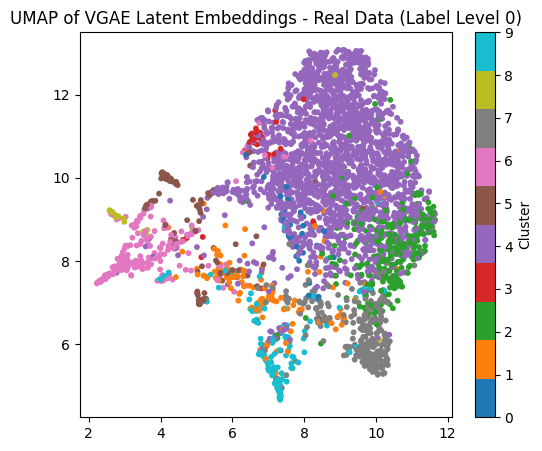

In [235]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset} (Label Level 0)")
plt.show()

In [ ]:
import seaborn as sns

result = pd.read_csv('result.csv')

sns.boxplot(data = result, x = "", y = 

In [234]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = cluster_bayes

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.2556
NMI: 0.3671
HOM: 0.3553


In [236]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture

# detach to CPU numpy
z_np = z.detach().cpu().numpy()
df_z = pd.DataFrame(z_np)

# Cluster for true label level 1
adata = adata_rna_real.copy()
adata.obs['label'] = adata.obs['true_label_level_1']
num_cluster = len(adata.obs['label'].unique())
bayes = BayesianGaussianMixture(n_components = num_cluster,
                                #init_params = "random",
                                random_state = 42,
                                #max_iter = 1000,
                                #tol = 1e-3
                                )
bayes.fit(df_z)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=8, random_state=42)

In [237]:
cluster_bayes = bayes.predict(df_z)
pred = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_bayes, k = 6)

C:\Users\hana2\miniconda3\envs\SpatialGlue\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


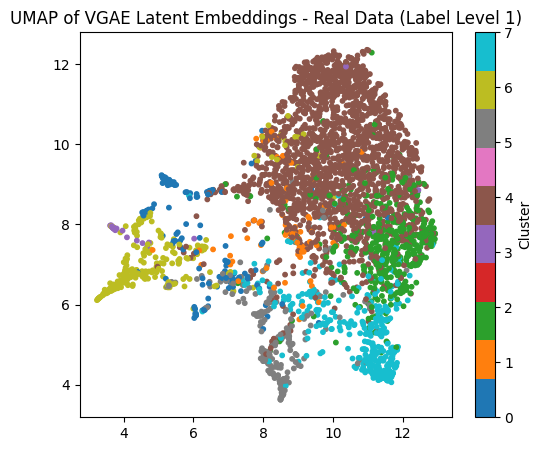

In [238]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.1, random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Scatter plot with cluster colors
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:,0], z_umap[:,1], c=pred, cmap="tab10", s=10)
plt.colorbar(label="Cluster")
plt.title(f"UMAP of VGAE Latent Embeddings - {dataset} (Label Level 1)")
plt.show()

In [239]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
import os

# True labels
labels_true = adata.obs['label'].values   # numpy array

# Predicted cluster labels
labels_pred = cluster_bayes

# Compute ARI and NMI
ARI = adjusted_rand_score(labels_true, labels_pred)
NMI = normalized_mutual_info_score(labels_true, labels_pred)
HOM = homogeneity_score(labels_true, labels_pred)

print(f"ARI: {ARI:.4f}")
print(f"NMI: {NMI:.4f}")
print(f"HOM: {HOM:.4f}")

# Save to a csv file
score = []
score.append([dataset, ARI, NMI, HOM])
score_df = pd.DataFrame(score, columns = ['DataName', 'ARI', 'NMI', 'HOM'])
output_file = "result.csv"
    #Check if the file exists
if os.path.exists(output_file):
    # Append without writing header
    score_df.to_csv(output_file, mode='a', header=False, index=False)
else:
    # First time: write header
    score_df.to_csv(output_file, mode='w', header=True, index=False)

ARI: 0.4608
NMI: 0.4094
HOM: 0.4627


### Plot result

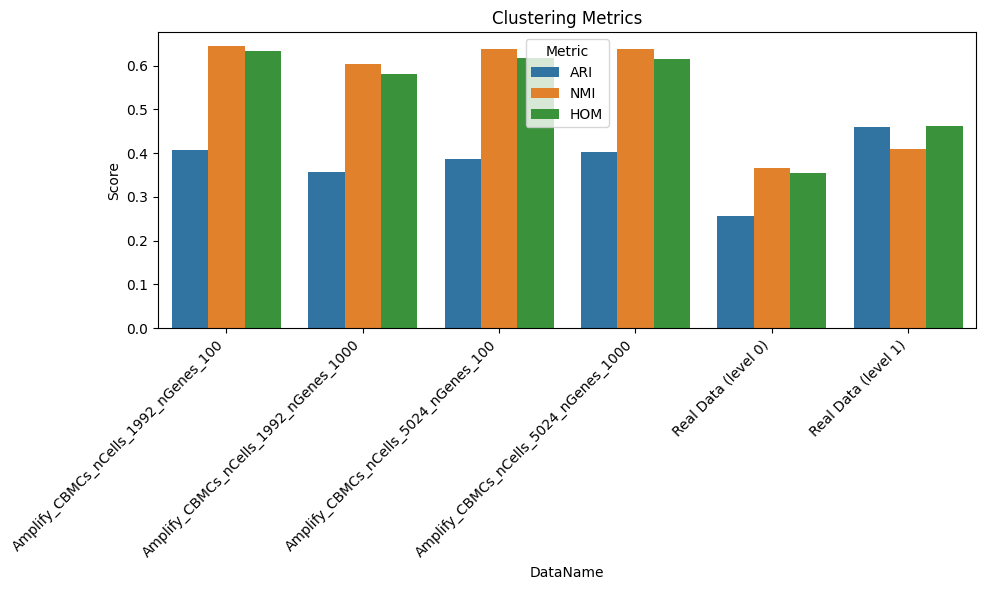

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("result.csv")
df_melted = df.melt(id_vars="DataName", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="DataName", y="Score", hue="Metric")
plt.title("Clustering Metrics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("result.png", dpi=300, bbox_inches="tight")
plt.show()
